# Support Vector Machine with Scaling the data

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
import warnings
warnings.filterwarnings("ignore")

Read the data

In [16]:
df = pd.read_csv('adult.data')

Removing all Columns without continuous attributes

In [17]:
popColumns = ['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'nativecountry']
for i in popColumns:
    df.pop(i)
pass

A method to standardize the 'salary' column since the data is in the form of string

In [18]:
arrSalary = np.zeros((df.shape[0],1))
for i in range(df.shape[0]):
    arrSalary[i][0] = -1 if df.iloc[i][6] == ' <=50K' else 1

A method to scale the data with mean 0 and standard deviation 1

In [19]:
def scaling(df):
    arrScaled = np.zeros((df.shape[0],df.columns.size))
    for i in range(df.columns.size-1):
        meanVal = df.iloc[:,i].mean()
        standardDev = df.iloc[:,i].std()
        for j in range(df.shape[0]):
            arrScaled[j][i] = (df.iloc[j][i]-meanVal)/standardDev
    return arrScaled

Initializing the required variables

In [42]:
arrScaled = scaling(df) # Scaling the data
dfScaled = pd.DataFrame(arrScaled) # Converting the scaled data to a dataframe
dfScaled.header = False # Removing the header
dfScaled[6] = arrSalary # Adding the salary column
y = dfScaled.pop(6) # Popping the salary column from the dataframe into y
X = dfScaled # Assigning the dataframe to X
accuracyList = [] # List to store the accuracy of each iteration
regStrength = 1e-2 # Regularization Strength, replace with 1e-3, 1e-1, and 1
learningRate = 0.1

Creating a custom SVM Class

In [43]:
# Source: Collaborated with Gaurav Kamath, USN: ENG20AM0023
class SVM:
    def __init__(self):
        global regStrength
        global learningRate

    def computeCost(self, W, X, Y):
        # calculate hinge loss
        M = X.shape[0]
        Y = np.array(Y)
        distances = 1 - Y.reshape(1, -1) * (np.dot(X, W))
        distances[distances < 0] = 0 
        hingeLoss = regStrength * (np.sum(distances) / M)
        cost = 1 / 2 * np.dot(np.transpose(W), W) + hingeLoss
        return cost
    
    def calcCostGradient(self, W, X_batch, Y_batch):
        Y_final= Y_batch.astype(np.float64)
        X_final = X_batch
        W_64 = W.astype(np.float64)
        distance = 1 - (Y_final * np.dot(X_final, W_64))
        dw = np.zeros(len(W_64))
        dw = dw.reshape(-1, 1)
        if all(item < 0 for item in distance):
            di = W_64
        else:
            x_test = W_64 - ((regStrength * Y_final) * X_final.reshape(-1, 1))
            di = x_test
        dw += di
        return dw
    
    def testAccuracy(self, X_test, weights):
        y_test_predicted = np.ndarray(shape=(len(X_test), 1))
        for i in range(X_test.shape[0]):
            yp = np.sign(np.dot(np.transpose(weights), X_test.to_numpy()[i])) #model
            y_test_predicted[i] = yp
        return y_test_predicted

    def validation(self, X_validate,weights, Y_validate):
        finalWeights = list(weights)
        results = self.testAccuracy(X_validate, finalWeights)
        a = accuracy_score(Y_validate, results)
        return (a / len(X_validate)) * 100

    def sgd(self, features, outputs, maxEpochs):
        weights = np.zeros(features.shape[1])
        weights = weights.reshape(-1, 1)
        epochs = 0
        previousCost = float("inf")
        costTreshold = 0.01  
        for epoch in range(1, maxEpochs):
            print(f"{epoch}", end = " ")
            X, Y = shuffle(features, outputs)
            for i in range(0, len(X), 300):
                if (i % 30 == 0):
                    validate = self.validation(features, weights, outputs)
                    accuracyList.append(validate)
                    try:
                        ascent = self.calcCostGradient(weights, np.array(X.iloc[[i]]), Y[i])
                        weights -= (learningRate * ascent)
                    except:
                        continue

            if epoch == maxEpochs:
                cost = self.computeCost(weights, features, outputs)
                print(f"Epoch is: {epoch} and Cost is: {cost}")

                if abs(previousCost - cost) < costTreshold * previousCost:
                    return weights
                previousCost = cost
                epochs += 1
        return weights
           
    def test(self, X_test, weights):
        y_test_predicted = np.ndarray(shape=(len(X_test), 1))
        for i in range(X_test.shape[0]):
            yp = np.sign(np.dot(np.transpose(weights), X_test.to_numpy()[i])) #model
            y_test_predicted[i] = yp
        return y_test_predicted

Splitting the data into training and testing data

In [44]:
X_train, X_test_val, y_train, y_test_val = tts(X, y, test_size=0.20, random_state=69)
X_test, X_val, y_test, y_val = tts(X_test_val, y_test_val, test_size=0.50, random_state=69)

Fitting the model

In [45]:
model = SVM() # Creating an object of the class
weights = model.sgd(X_train, y_train, maxEpochs=100) # Training the model

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Testing the model

In [46]:
dfFinal = pd.DataFrame(model.test(X_val, weights), columns=['y_test_predicted'])
cm(y_val, dfFinal['y_test_predicted'])

array([[1461, 1032],
       [ 180,  584]])

Printing the confusion matrix

In [47]:
print(cr(y_val, dfFinal['y_test_predicted']))

              precision    recall  f1-score   support

        -1.0       0.89      0.59      0.71      2493
         1.0       0.36      0.76      0.49       764

    accuracy                           0.63      3257
   macro avg       0.63      0.68      0.60      3257
weighted avg       0.77      0.63      0.66      3257



Plotting the Accuracy Graph

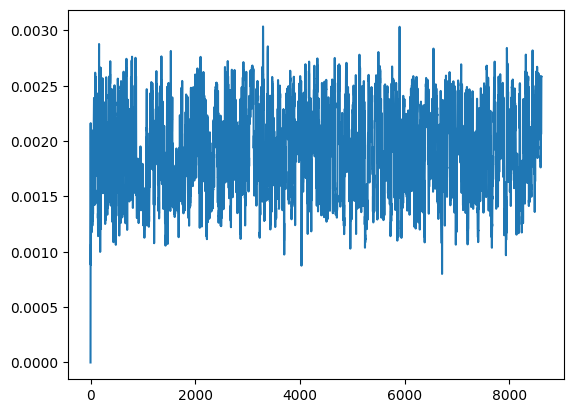

In [41]:
plt.plot(accuracyList)